# Model Calibration

https://www.kaggle.com/code/residentmario/notes-on-classification-probability-calibration/notebook

https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

When performing classification one often wants to predict not only the class label, but also the associated probability. This probability gives some kind of confidence on the prediction. This example demonstrates how to visualize how well calibrated the predicted probabilities are using calibration curves, also known as reliability diagrams. Calibration of an uncalibrated classifier will also be demonstrated.

In [42]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve

from xgboost import XGBClassifier as xgbclassifier

from catboost import CatBoostClassifier, Pool, metrics

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings('ignore')

In [13]:
'''
always enable this extension everytime working with catboost
'''
!jupyter nbextension enable --py widgetsnbextension 
%matplotlib inline

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
'''
populate synthetic dataset
'''
X, y = make_classification(n_samples=100_000, n_features=20, n_informative=2, n_redundant=10, random_state=42)

'''
train test split
'''
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.99, random_state=42)

***

### Model calibration and display using `CalibrationDisplay.from_estimator` [scikit-learn]

In [3]:
'''
create model objects for 
comparisons, pay attention how GaussianNB is initiated
'''
log_reg = LogisticRegression(C=1.0)
gnb = GaussianNB()
isotonic_args = {
    'base_estimator': gnb, #we re-use gnb object
    'cv': 2, 
    'method': 'isotonic'
}
gnb_isotonic = CalibratedClassifierCV(**isotonic_args)

sigmoid_args = isotonic_args
sigmoid_args['method'] = 'sigmoid'
gnb_sigmoid = CalibratedClassifierCV(**sigmoid_args)

clf_list = [
    (log_reg, 'Logistic Regression'),
    (gnb, 'Naive Bayes'),
    (gnb_isotonic, 'Naive Bayes + isotonic'),
    (gnb_sigmoid, 'Naive Bayes + sigmoid')
]

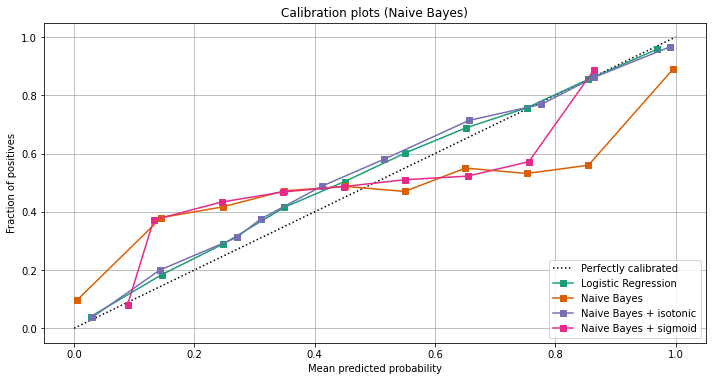

In [4]:
'''
Important: Calibration always using validation dataset
Do training and calibration, display calibartion using CalibrationDisplay.from_estimator
'''
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap('Dark2')

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    '''
    train
    '''
    clf.fit(X_train, y_train)
    '''
    display
    '''
    display_args = {
        'estimator': clf,
        'X': X_validation,
        'y': y_validation,
        'n_bins': 10, 
        'name': name,
        'ax': ax_calibration_curve,
        'color': colors(i)
    }
    display = CalibrationDisplay.from_estimator(**display_args)
    calibration_displays[name] = display
    
ax_calibration_curve.grid()
ax_calibration_curve.set_title('Calibration plots (Naive Bayes)')
plt.tight_layout()
plt.show()

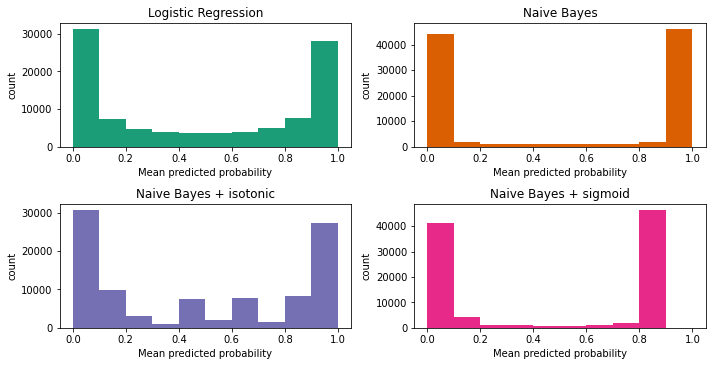

In [5]:
'''
display calibrated histogram
'''
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    '''
    display histogram
    '''
    hist_args = {
        'x': calibration_displays[name].y_prob,
        'range': (0, 1),
        'bins': 10,
        'label': name,
        'color': colors(i)
    }
    ax.hist(**hist_args)
    ax.set(title=name, xlabel='Mean predicted probability', ylabel='count')
    
plt.tight_layout()
plt.show()

### Model calibration and display manually [scikit-learn]

In [6]:
'''
Manually create calibration display

Important: To display calibration manually we need fraction_of_positives and mean_predicted_value
using calibration_curve function
'''
gnb = GaussianNB().fit(X_train, y_train)
y_predict_proba_uncalibrated = gnb.predict_proba(X_validation)[:, 1]
uncalibrated_fraction_of_positives, uncalibrated_mean_predicted_value = calibration_curve(y_validation, 
                                                                                          y_predict_proba_uncalibrated,
                                                                                          n_bins=10)
print('Uncalibrated fraction of positives and mean predicted value')
print('-----------------------------------------------------------')
print(uncalibrated_fraction_of_positives)
print(uncalibrated_mean_predicted_value)
print()
isotonic_args = {
    'base_estimator': gnb, #we re-use gnb object
    'cv': 2, 
    'method': 'isotonic'
}
gnb_isotonic = CalibratedClassifierCV(**isotonic_args).fit(X_train, y_train)
y_predict_proba_calibrated = gnb_isotonic.predict_proba(X_validation)[:, 1]
calibrated_fraction_of_positives, calibrated_mean_predicted_value = calibration_curve(y_validation, 
                                                                                        y_predict_proba_calibrated,
                                                                                        n_bins=10)
print('Calibrated fraction of positives and mean predicted value')
print('-----------------------------------------------------------')
print(calibrated_fraction_of_positives)
print(calibrated_mean_predicted_value)

Uncalibrated fraction of positives and mean predicted value
-----------------------------------------------------------
[0.09662528 0.38006231 0.41674249 0.47188534 0.48717949 0.46980676
 0.55005624 0.53144376 0.55985037 0.88859273]
[0.0048196  0.14511296 0.24690642 0.34968244 0.44977583 0.54964127
 0.6507266  0.75279854 0.85521245 0.99530145]

Calibrated fraction of positives and mean predicted value
-----------------------------------------------------------
[0.03777517 0.19969512 0.31207946 0.375      0.48808732 0.58083832
 0.71354504 0.76923077 0.861662   0.96589623]
[0.03032985 0.1422874  0.27057935 0.30993824 0.41212844 0.5159054
 0.65625652 0.77712989 0.86465281 0.99027036]


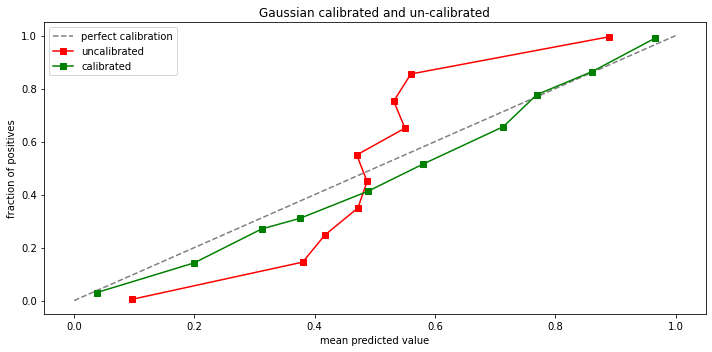

In [7]:
'''
plot
'''
fig, ax=plt.subplots(1, figsize=(10, 5))
plt.plot([0, 1], [0, 1], '--', color='gray', label='perfect calibration')
plt.plot(uncalibrated_fraction_of_positives, uncalibrated_mean_predicted_value,
         's-', color='red', label='uncalibrated')
plt.plot(calibrated_fraction_of_positives, calibrated_mean_predicted_value, 
         's-', color='green', label='calibrated')
plt.title('Gaussian calibrated and un-calibrated')
plt.legend()
plt.xlabel('mean predicted value')
plt.ylabel('fraction of positives')
plt.tight_layout()
plt.show()

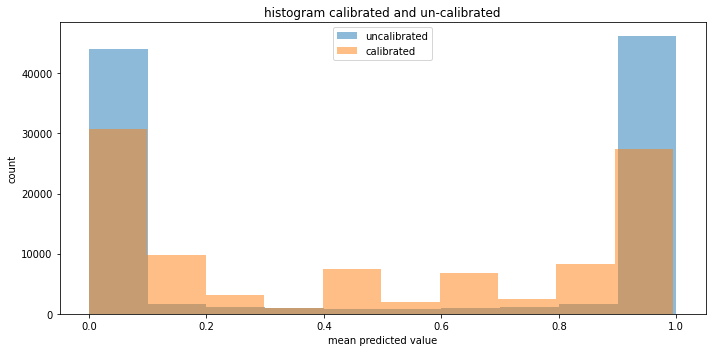

In [8]:
'''
plot histogram calibrated and un-calibrated

first we need to get predict_proba using x_validation
'''
uncalibrated_predict_proba = gnb.predict_proba(X_validation)[:, 1]
calibrated_predict_proba = gnb_isotonic.predict_proba(X_validation)[:, 1]
fig, ax=plt.subplots(1, figsize=(10, 5))
plt.hist(uncalibrated_predict_proba, bins=10, alpha=0.5, label='uncalibrated')
plt.hist(calibrated_predict_proba, bins=10, alpha=0.5, label='calibrated')
plt.legend()
plt.xlabel('mean predicted value')
plt.ylabel('count')
plt.title('histogram calibrated and un-calibrated')
plt.tight_layout()
plt.show()

***

### Model comparison between calibrated and un-calibrated model

In [9]:
uncalibrated_roc_auc_score = roc_auc_score(y_validation, gnb.predict_proba(X_validation)[:, 1])
calibrated_roc_auc_score = roc_auc_score(y_validation, gnb_isotonic.predict_proba(X_validation)[:, 1])
score_df = pd.DataFrame({
    'model_name': ['uncalibrated', 'calibrated'],
    'roc_auc_score': [uncalibrated_roc_auc_score, calibrated_roc_auc_score]
})
score_df = score_df.round(decimals=3)
score_df

,model_name,roc_auc_score
0,uncalibrated,0.940
1,calibrated,0.939


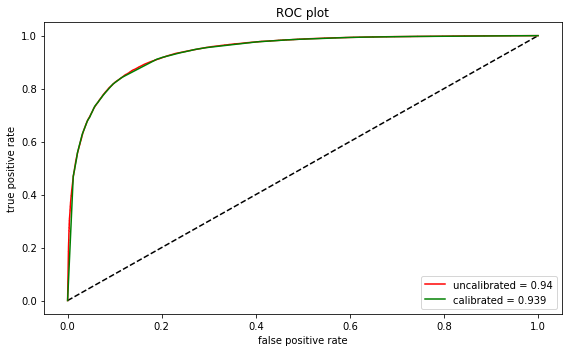

In [10]:
'''
plot roc-auc

get false_positive_rate and true_positive_rate
'''
uncalibrated_predict_proba = gnb.predict_proba(X_validation)[:, 1]
uncalibrated_fpr, uncalibrated_tpr, _ = roc_curve(y_validation, uncalibrated_predict_proba)
calibrated_predict_proba = gnb_isotonic.predict_proba(X_validation)[:, 1]
calibrated_fpr, calibrated_tpr, _ = roc_curve(y_validation, calibrated_predict_proba)

plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], '--', color='black')
plt.plot(uncalibrated_fpr, uncalibrated_tpr, label=f"uncalibrated = {score_df.loc[0, 'roc_auc_score']}", color='red')
plt.plot(calibrated_fpr, calibrated_tpr, label=f"calibrated = {score_df.loc[1, 'roc_auc_score']}", color='green')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC plot')
plt.tight_layout()
plt.show()

***

### Model calibration using xgboost and catboost

Important: `CalibratedClassifierCV` is a `Scikit-learn` class so it could only takes numeric features

In [35]:
'''
Catboost
'''
params = {
    'random_seed': 42, 
    'logging_level': 'Silent'
}
uncalibrated_model = CatBoostClassifier(**params)

calibrated_params = {
    'base_estimator': uncalibrated_model, #we re-use un-calibrated object
    'cv': 2, 
    'method': 'isotonic'
}
calibrated_model = CalibratedClassifierCV(**calibrated_params)

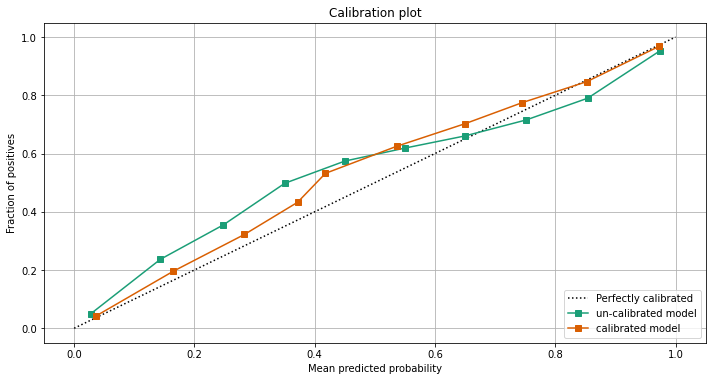

In [34]:
'''
Catboost calibration and un-calibration
'''
clf_list = [
    (uncalibrated_model, 'un-calibrated model'),
    (calibrated_model, 'calibrated model')
]
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap('Dark2')
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (clf, name) in enumerate(clf_list):
    '''
    train
    '''
    clf.fit(X_train, y_train)
    '''
    display
    '''
    display_args = {
        'estimator': clf, 
        'X': X_validation, 
        'y': y_validation,
        'n_bins': 10,
        'name': name,
        'ax': ax_calibration_curve,
        'color': colors(i)
    }
    display = CalibrationDisplay.from_estimator(**display_args)
    calibration_displays[name] = display
    
ax_calibration_curve.grid()
ax_calibration_curve.set_title('Calibration plot')
plt.tight_layout()
plt.show()

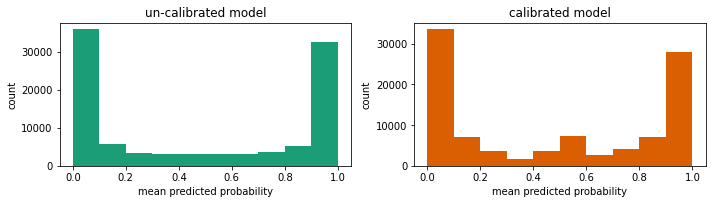

In [25]:
'''
display calibrated histogram
'''
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap('Dark2')
grid_positions = [(2, 0), (2, 1)]

for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    '''
    display histogram
    '''
    hist_args = {
        'x': calibration_displays[name].y_prob,
        'range': (0, 1),
        'bins': 10,
        'label': name,
        'color': colors(i)
    }
    ax.hist(**hist_args)
    ax.set(title=name, xlabel='mean predicted probability', ylabel='count')

plt.tight_layout()
plt.show()

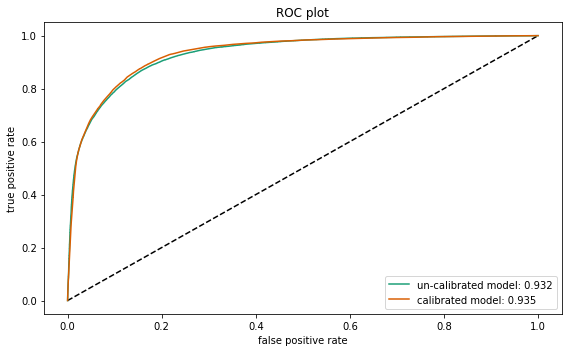

In [46]:
'''
un-calibrated and calibrated model comparison 
'''
fig = plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], '--', color='black') 
colors = plt.cm.get_cmap('Dark2')

for i, (clf, name) in enumerate(clf_list):
    predicts_proba = clf.predict_proba(X_validation)[:, 1]
    roc_auc_score_ = roc_auc_score(y_validation, predicts_proba)
    fpr, tpr, _ = roc_curve(y_validation, predicts_proba)
    plt.plot(fpr, tpr, label=f'{name}: {roc_auc_score_:.3f}', color=colors(i))

plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC plot')
plt.tight_layout()
plt.show()

In [40]:
'''
XGBoost
'''
params = {
    'base_score': 0.5, 
    'booster': 'gbtree',
    'max_depth': 3, 
    'eval_metric': 'logloss'
}
uncalibrated_model = xgbclassifier(**params)

calibrated_params = {
    'base_estimator': uncalibrated_model, #we re-use un-calibrated model
    'cv': 2,
    'method': 'isotonic'
}
calibrated_model = CalibratedClassifierCV(**calibrated_params)

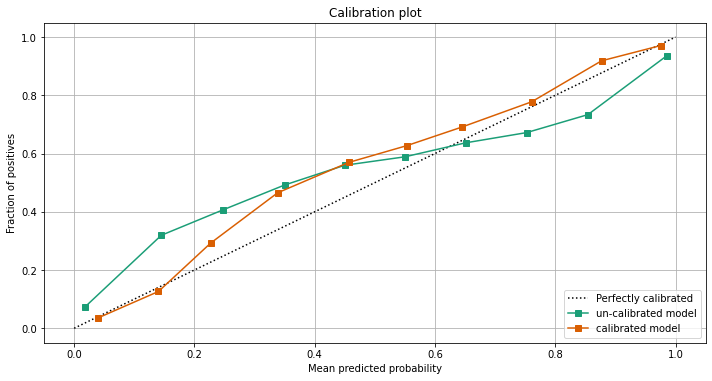

In [44]:
'''
XGBoost calibration and un-calibration
'''
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap('Dark2')
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

clf_list = [
    (uncalibrated_model, 'un-calibrated model'),
    (calibrated_model, 'calibrated model')
]
for i, (clf, name) in enumerate(clf_list):
    '''
    train
    '''
    clf.fit(X_train, y_train)
    '''
    display
    '''
    display_args = {
        'estimator': clf, 
        'X': X_validation, 
        'y': y_validation, 
        'n_bins': 10, 
        'name': name,
        'ax': ax_calibration_curve,
        'color': colors(i)
    }
    display = CalibrationDisplay.from_estimator(**display_args)
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title('Calibration plot')
plt.tight_layout()
plt.show()

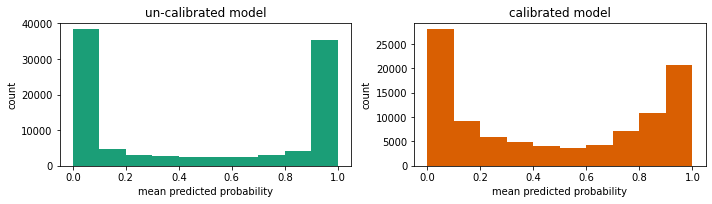

In [45]:
'''
display calibrated historam
'''
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap('Dark2')
grid_positions = [(2, 0), (2, 1)]

for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    '''
    display histogram
    '''
    hist_args = {
        'x': calibration_displays[name].y_prob,
        'range': (0, 1),
        'bins': 10, 
        'label': name, 
        'color': colors(i)
    }
    ax.hist(**hist_args)
    ax.set(title=name, xlabel='mean predicted probability', ylabel='count')

plt.tight_layout()
plt.show()

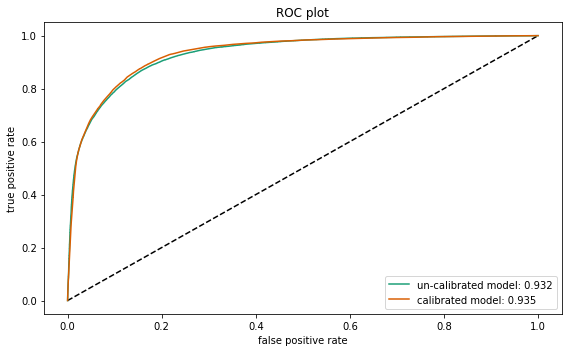

In [47]:
'''
un-calibrated and calibrated model comparison
'''
fig = plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], '--', color='black')
colors = plt.cm.get_cmap('Dark2')

for i, (clf, name) in enumerate(clf_list):
    predicts_proba = clf.predict_proba(X_validation)[:, 1]
    roc_auc_score_ = roc_auc_score(y_validation, predicts_proba)
    fpr, tpr, _ = roc_curve(y_validation, predicts_proba)
    plt.plot(fpr, tpr, label=f'{name}: {roc_auc_score_:.3f}', color=colors(i))
    
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC plot')
plt.tight_layout()
plt.show()